### STOCK NLP

project by Anthony Pirvuti

- Aims to create an application that can measure the optimism surrounding a stock based on the wording used in a article
- usage of nklt for nlp
- selenium for webscrapping
- flask for simple webpage



In [1]:
import nltk
import os
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

from ArticleScraper import scrape_yahoo_finance_articles

from PersistentDict import PersistentDict

# downloads
nltk.download([ "names","stopwords","averaged_perceptron_tagger","vader_lexicon","punkt"])

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\Anthony\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anthony\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Anthony\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Anthony\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Anthony\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Access the articles

In [2]:
yahoo_list = scrape_yahoo_finance_articles()

Sentiment Analysis

In [3]:
def sentimentAnalysis(filtered_words):
    """performs sentiment analysis on a given string of words

    Args:
        filtered_words (list(str)): list of filtered words

    Returns:
        list(list(str)): positive and negative words/scores
    """
    sia = SentimentIntensityAnalyzer()
    positive_words = []
    positive_scores = []
    negative_words = []
    negative_scores = []

    # for floating point precision
    epsilon = 1e-5

    for word in filtered_words:
        scores = sia.polarity_scores(word)
    
        # check if the word is postive or not (ignore balanced words)
        if (scores["compound"] >= (0.15 + epsilon)):
            positive_words.append(word)
            positive_scores.append(scores["compound"])
        elif (scores["compound"] <= (-0.15 - epsilon)):
            negative_words.append(word)
            negative_scores.append(scores["compound"])
    
    return [positive_words, positive_scores, negative_words, negative_scores]

Statsical Analysis

In [4]:
# calculating weighted average of the words 
# words[i] * occurence of words[i] / total occurences

def weightedAverage(filtered_words, sentiments):
    """calculates the weighted postive/negative average of a tokenized sentence

    Args:
        filtered_words (str): original tokenized string
        sentiments (list(list(str)): collection of sentiment scores and words
    """
    # sentiments = pos_words, pos_scores, neg_words, neg_scores
    

    # positive words
    positive_weights = np.array([])
    positive_scores = np.array(sentiments[1])

    for word in sentiments[0]:
        positive_weights = np.append(positive_weights, filtered_words.count(word))

    positive_avg = np.average(positive_scores, weights=positive_weights) if len(positive_scores != 0) else 0.00


    # negative words
    negative_weights = np.array([])
    negative_scores = np.array(sentiments[3])

    for word in sentiments[2]:
        negative_weights = np.append(negative_weights, filtered_words.count(word))

    negative_avg = np.average(negative_scores, weights=negative_weights) if len(negative_scores != 0) else 0.00
    
    
    return positive_avg, negative_avg
    
    
    

Initialize data access

In [5]:
data_path = os.path.abspath('data.json')

# accesses a json
persistent_dict = PersistentDict(data_path)


Proccess articles

In [6]:
stop_words = set(stopwords.words("english"))


for article in yahoo_list:
    author = article[0].lower()
    words_in_article = word_tokenize(article[1])
    
    # remove extraneous words
    filtered_words = [word.lower() for word in words_in_article if word.casefold() not in stop_words]

    filtered_words
    
    
    pos_avg, neg_avg = weightedAverage(filtered_words, sentimentAnalysis(filtered_words))
    
    print(f"author: {author}, positive score: {pos_avg}, negative average: {neg_avg}")
    
    
    # store data in json
    scores_for_author = persistent_dict.get_numbers(author)
    
    if scores_for_author != (None, None):
        new_pos_score = (scores_for_author[0] + pos_avg) / 2
        new_neg_score = (scores_for_author[1] + neg_avg) / 2
        persistent_dict.set_numbers(author, new_pos_score, new_neg_score)
    else:
        persistent_dict.set_numbers(author, pos_avg, neg_avg)

persistent_dict.save()


author: yahoo finance, positive score: 0.0, negative average: -0.4019
author: reuters, positive score: 0.0, negative average: -0.296
author: yahoo finance, positive score: 0.4019, negative average: -0.2263
author: yahoo finance, positive score: 0.0, negative average: -0.2023
author: reuters, positive score: 0.0, negative average: 0.0


Visualize Data

Name: motley fool, Numbers: 0.35372382812500003, -0.01193125
Name: yahoo finance, Numbers: 0.11486607828140258, -0.23761797637939452
Name: reuters, Numbers: 0.0, -0.09828124999999999
Name: bloomberg, Numbers: 0.0, -0.5382333333333333


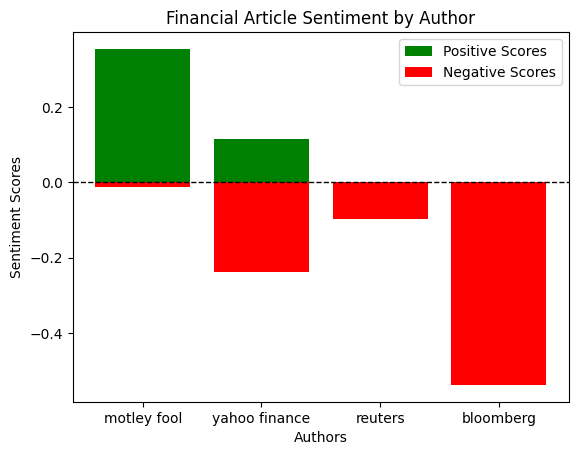

<Figure size 640x480 with 0 Axes>

In [7]:
data_dict = persistent_dict.data
authors = []
pos_scores = []
neg_scores = []

# loop through all the entries in the dict
for name, numbers in data_dict.items():
    print(f"Name: {name}, Numbers: {numbers[0]}, {numbers[1]}")
    authors.append(name)
    pos_scores.append(numbers[0])
    neg_scores.append(numbers[1])
    
x = np.arange(len(authors))
plt.bar(x, pos_scores, color='green', label='Positive Scores')
plt.axhline(0, color='black', linestyle='dashed', linewidth=1)
plt.bar(x, neg_scores, color='red', label='Negative Scores')

plt.xlabel('Authors')
plt.ylabel('Sentiment Scores')
plt.title('Financial Article Sentiment by Author')

plt.xticks(x, authors)

plt.legend()

plt.show()


# for webapp
plt.savefig('existing_plot.png')